In [2]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
main_dir = '/kaggle/input'
main_data_dir = 'mayo-clinic-strip-ai'

os.listdir(os.path.join(main_dir, main_data_dir))

['sample_submission.csv',
 'other',
 'train.csv',
 'test.csv',
 'test',
 'other.csv',
 'train']

In [4]:
%%time
# Get CSV files
train_df = pd.read_csv(os.path.join(main_dir, main_data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(main_dir, main_data_dir, 'test.csv'))
other_df = pd.read_csv(os.path.join(main_dir, main_data_dir, 'other.csv'))

print(f"The # of training samples : {len(train_df)}")
print(f"The # of supplementary samples : {len(other_df)}")
print(f"The # of test samples : {len(test_df)}")

The # of training samples : 754
The # of supplementary samples : 396
The # of test samples : 4
CPU times: user 9.11 ms, sys: 1.01 ms, total: 10.1 ms
Wall time: 21.1 ms


In [8]:
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


(array([547.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 207.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

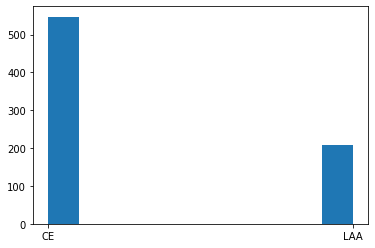

In [9]:
plt.hist(train_df['label'])

In [10]:
# Check if all images exist in train folder
for i in range(len(train_df)):
    image_id = f"{train_df.iloc[i,0]}.tif"   
    image_id = os.path.join(main_dir, main_data_dir, 'train', image_id)
    assert os.path.isfile(image_id), f"{image_id} does not exists"
else:
    print("All Images found")

All Images found


In [11]:
train_df.iloc[:5,0] + ".tif"

0    006388_0.tif
1    008e5c_0.tif
2    00c058_0.tif
3    01adc5_0.tif
4    026c97_0.tif
Name: image_id, dtype: object

# Pytorch

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import skimage
from skimage import io
from skimage import transform as sk_tf
from torchvision import transforms, utils
from torchmetrics import Accuracy
from tqdm.auto import tqdm

## Utility Functions

In [6]:
class Mayo_Dataset(Dataset):
    'Dataset for Mayo Clinic'
    def __init__(self, csv_file, root_dir, transform=None, TEST = False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.TEST = TEST
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        label = self.df.iloc[idx, 4]
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0] + ".tif")
        image = io.imread(img_name)

        if self.transform is not None:
            image = self.transform(image)
        
        if self.TEST:
            return image

        return image, label
    
    

In [7]:
import random
def seed_everything(seed: int):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(3407)

In [8]:
def train(data, target, model, optimizer, criterion, TRAIN):

    if TRAIN:
        optimizer.zero_grad()

    # forward pass
    output = model(data)
    loss = criterion(output, target)

    if TRAIN:
        # backward pass
        loss.backward()  
        # Update the parameters
        optimizer.step()     

    return output, loss

## Copy Resized Images to a New Directory

In [9]:
target_dir = 'Train_dir'
source_dir = os.path.join(main_dir, main_data_dir, 'train')
train_df = pd.read_csv(os.path.join(main_dir, main_data_dir, 'train.csv'))

In [ ]:
# Check if all images exist in train folder
os.makedirs(target_dir, exist_ok = True)
for i in tqdm(range(len(train_df))):
    image_id = f"{train_df.iloc[i,0]}.tif"   
    src_file = os.path.join(main_dir, main_data_dir, 'train', image_id)    
    des_file = os.path.join(target_dir,image_id)
    
    image = io.imread(src_file)
    image = sk_tf.resize(image, (224, 224), preserve_range=True)
    io.imsave(des_file, image)
    print(src_file, des_file)
    break
else:
    print("All Images found")

  0%|          | 0/754 [00:00<?, ?it/s]

In [10]:
# composed = transforms.Compose([Rescale(256),RandomCrop(224)])



## Train

In [16]:
basic_tfs = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224)), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_ds = Mayo_Dataset(csv_file = os.path.join(main_dir, main_data_dir, 'train.csv'),
                        root_dir = os.path.join(main_dir, main_data_dir, 'train'),
                        transform = basic_tfs, TEST = False)
train_dl = DataLoader(train_ds, 4, shuffle = True, pin_memory=True)

In [17]:
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = torch.nn.Linear(num_ftrs, 2)

model = model.to('cuda')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2048


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3) 

criterion = torch.nn.CrossEntropyLoss() 

# training device  ('cpu', 'cuda')
device = 'cuda'
model.to(device)

# number of training epochs
n_epochs = 5

# train for N epochs
loss_df = pd.DataFrame(columns= ['Train'])
acc_df = pd.DataFrame(columns= ['Train'])


acc = Accuracy().to(device)
print(f"\nTraining Model")
for epoch in tqdm(range(n_epochs), desc = "# Epochs", position= 0):
    train_loss = 0
    val_loss = 0
    test_loss = 0

    train_acc = 0
    val_acc = 0
    test_acc = 0

    # set to train mode
    model.train()

    for i, (data, target) in enumerate(tqdm(train_dl, desc = "Training", leave= False, position= 1)):
        # data to gpu/cpu
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

        # mini batch training
        output, loss = train(data, target, model, optimizer, criterion, TRAIN= True)

        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)
        _, output = torch.max(output, dim=1) 
        acc(output, target.squeeze())

    # Compute Loss for each epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = acc.compute().item()
    acc.reset()
    loss_df.loc[epoch+1, :] = [train_loss]
    acc_df.loc[epoch+1, :] = [train_acc]
    print(f"Epoch # {epoch+1:04d}")
    print(f"Train Loss: {train_loss: .4f}")
    print(f"Train Acc : {train_acc: .4f}")  
    
# Save Model
print(f"\nSaving Model...")
torch.save(model.state_dict(), os.path.join('Model', 'model.pt'))


Training Model


# Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/189 [00:00<?, ?it/s]

1 torch.Size([3, 224, 224]) CE


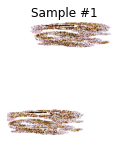

In [12]:
plt.figure(figsize = (8,8))

for i in range(1,4):
    X, y = train_ds[i]
    print(i, X.shape, y)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    plt.imshow(X.permute(1, 2, 0))
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    break

(-0.5, 223.5, 223.5, -0.5)

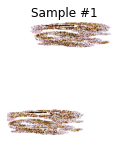

In [19]:
plt.figure(figsize = (8,8))
ax = plt.subplot(1, 4, i + 1)
plt.tight_layout()
# plt.imshow(X.moveaxis(0,-1).moveaxis(0,1))

ax.set_title('Sample #{}'.format(i))
ax.axis('off')